In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
from software.tasks import run_back_test
import mplfinance as mpf

%matplotlib inline
sns.set_style('darkgrid')

start_date = "2024-10-14 09:30:00"
end_date = "2024-10-14 15:00:00"
period = "1d"
ticker = "MSFT"
interval = "1m"
initial_cash = 1000

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
period_data = f"{start_date}_{end_date}"
data = process_data(data, ticker=ticker, period=period_data)

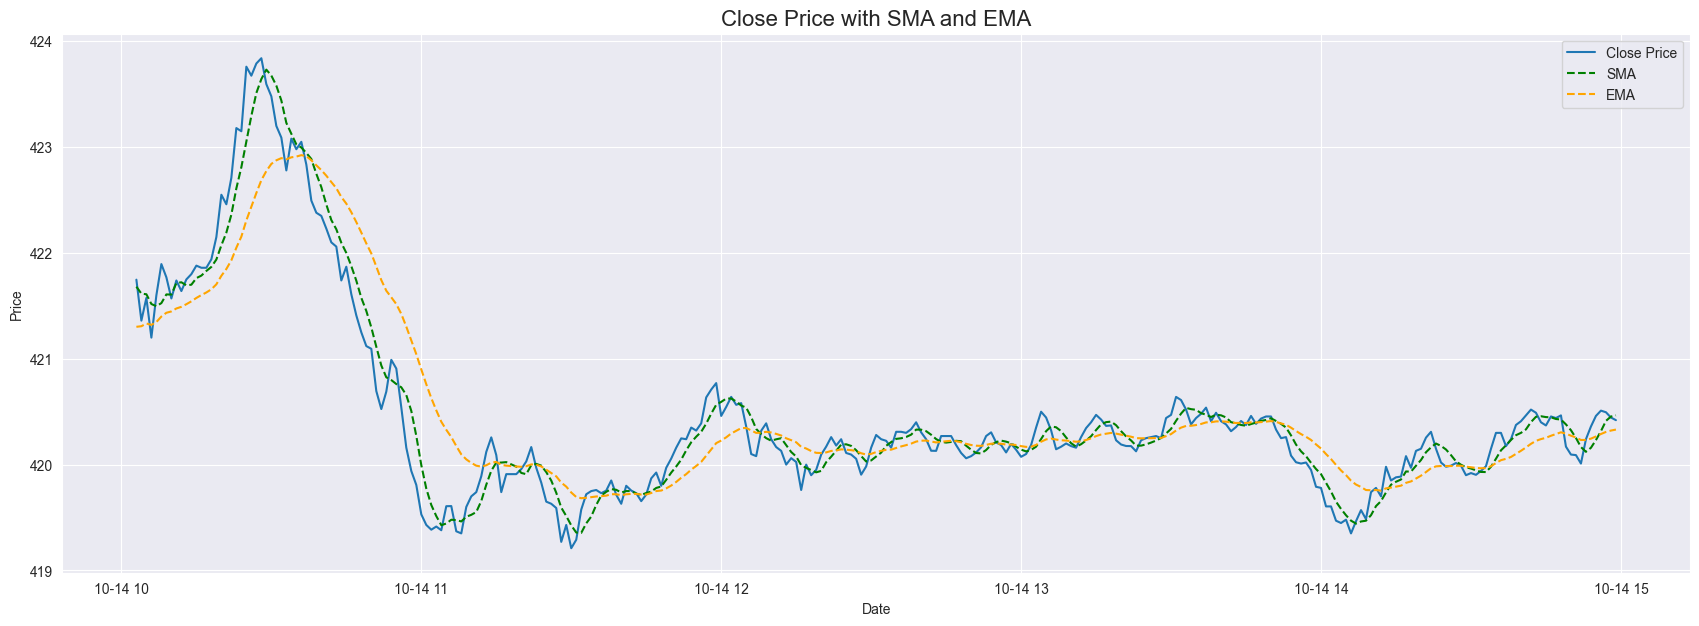

In [29]:
from software.plot_draws import plot_ema_and_sma


plot_ema_and_sma(data)

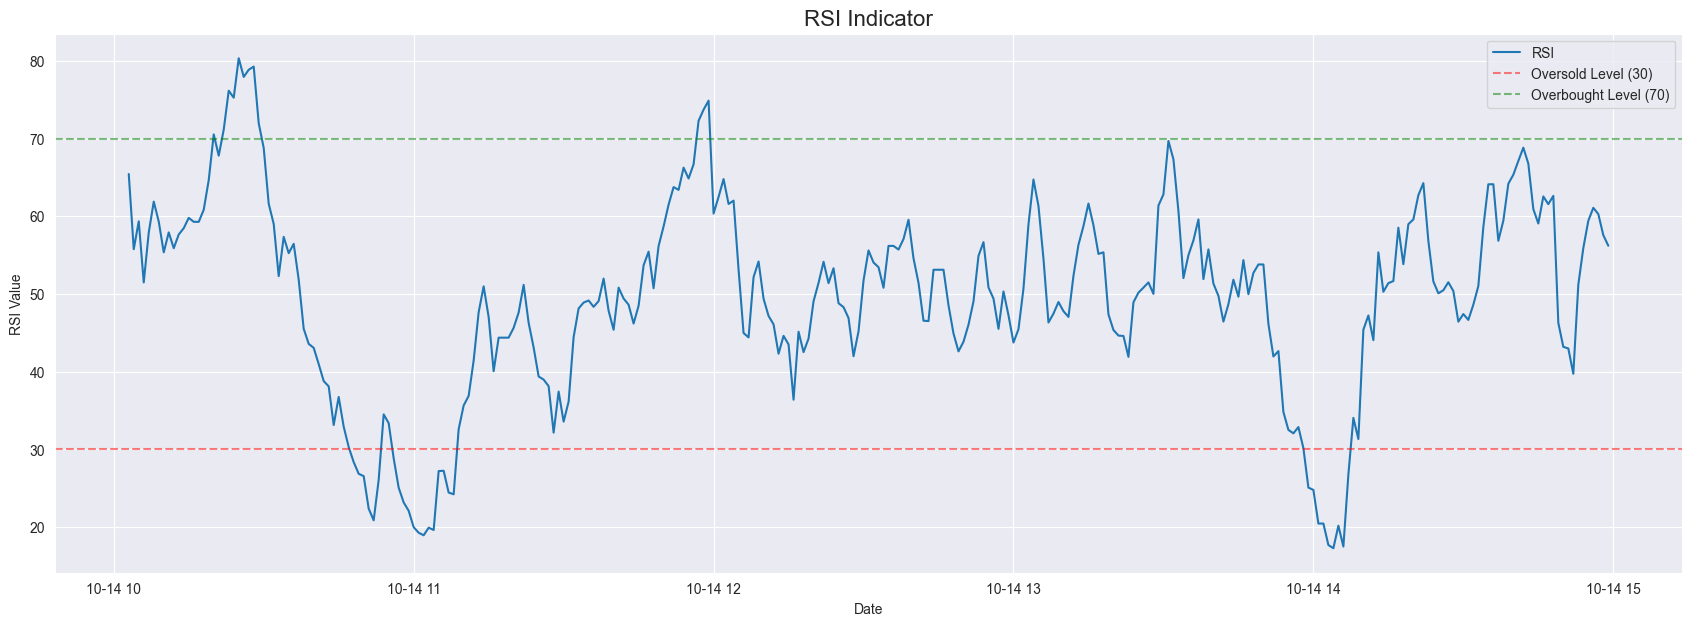

In [30]:
from software.plot_draws import plot_rsi

plot_rsi(data)

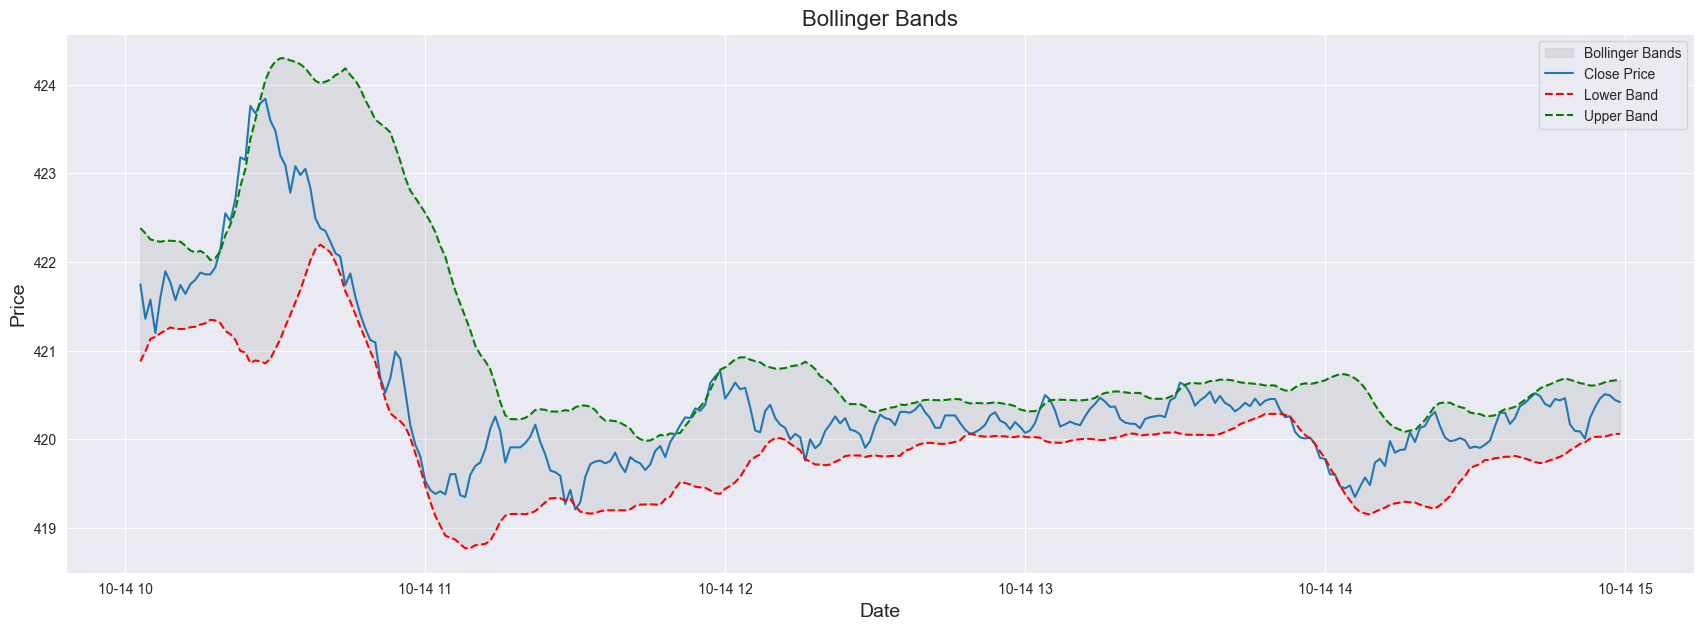

In [31]:
from software.plot_draws import plot_bollinger_bands

plot_bollinger_bands(data)

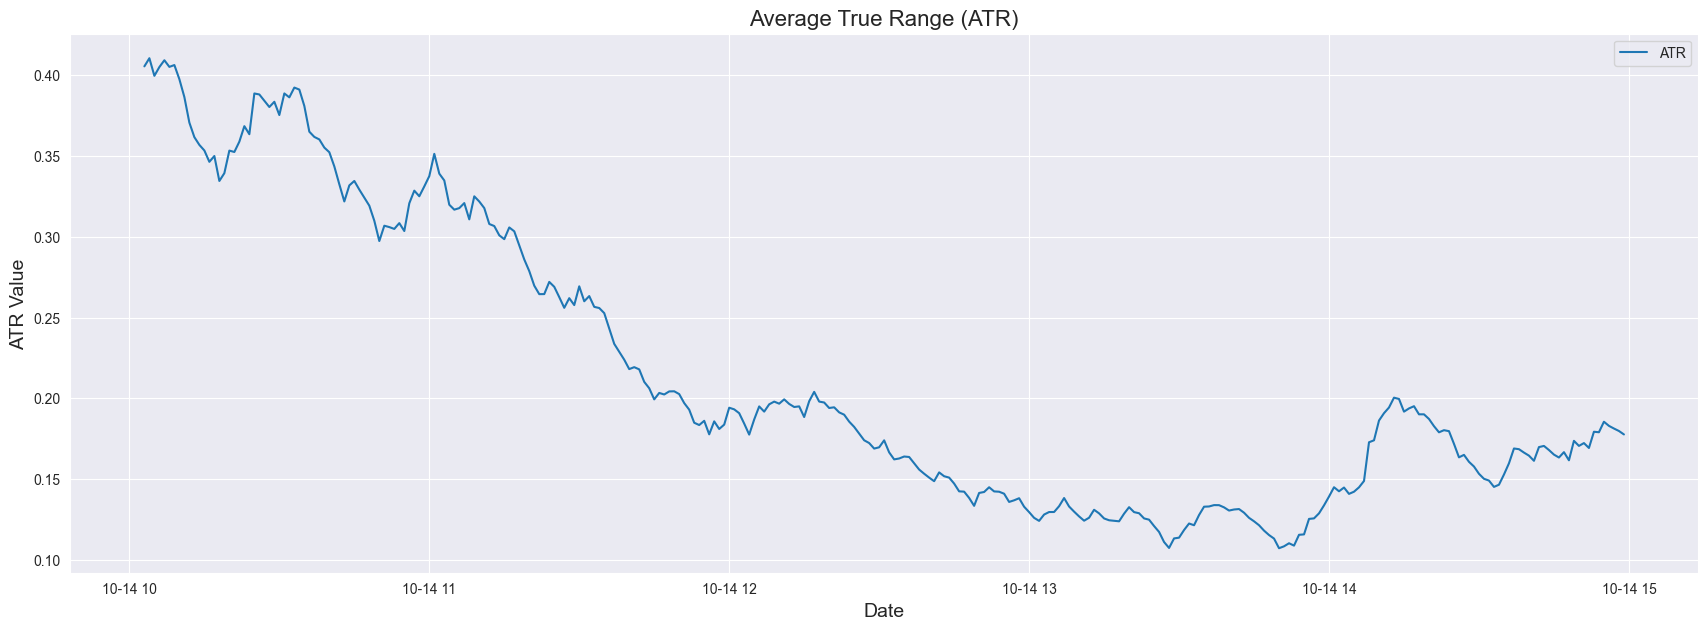

In [32]:
from software.plot_draws import plot_atr

plot_atr(data)

In [33]:
from software.strategy import generate_signals


processed_data = generate_signals(data)

print("processed_data.head(): ", processed_data.head(), "\n")
print("data.columns: ", data.columns, "\n")

processed_data.head():                             Signal       Close        High         Low  \
Datetime                                                                
2024-10-14 10:03:00-04:00    -1.0  421.747498  421.790009  421.600006   
2024-10-14 10:04:00-04:00     0.0  421.360596  421.750000  421.279999   
2024-10-14 10:05:00-04:00     0.0  421.575012  421.630005  421.387512   
2024-10-14 10:06:00-04:00     0.0  421.200012  421.600006  421.130005   
2024-10-14 10:07:00-04:00     0.0  421.600006  421.600006  421.140015   

                           ATR_Stop_Loss  ATR_Take_Profit  
Datetime                                                   
2024-10-14 10:03:00-04:00       0.607907         1.215815  
2024-10-14 10:04:00-04:00       0.615450         1.230899  
2024-10-14 10:05:00-04:00       0.599135         1.198270  
2024-10-14 10:06:00-04:00       0.607261         1.214522  
2024-10-14 10:07:00-04:00       0.613577         1.227154   

data.columns:  Index(['Open', 'High', 'Low

In [34]:
result = run_back_test(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
)

Running back tests for MSFT from 2024-10-14 09:30:00 to 2024-10-14 15:00:00...
Preparing market data for backtest...
Running backtest...


Executing trades: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 56522.38it/s]

Backtest completed successfully.
{'start_date': '2024-10-14 09:30:00', 'end_date': '2024-10-14 15:00:00', 'num_frames': 329, 'num_operations': 43, 'transactions': [{'action': 'open', 'position_type': 'short', 'price': 421.74749755859375, 'amount': 23.687182610068884, 'date': Timestamp('2024-10-14 10:03:00-0400', tz='America/New_York')}, {'action': 'close', 'position_type': 'short', 'price': 422.7612627868652, 'amount': 23.687182610068884, 'date': Timestamp('2024-10-14 10:20:00-0400', tz='America/New_York'), 'pnl': -24.01324208580373}, {'action': 'open', 'position_type': 'short', 'price': 422.7799987792969, 'amount': 23.638807943909352, 'date': Timestamp('2024-10-14 10:33:00-0400', tz='America/New_York')}, {'action': 'open', 'position_type': 'long', 'price': 422.05999755859375, 'amount': 4.305483205766895e-15, 'date': Timestamp('2024-10-14 10:43:00-0400', tz='America/New_York')}, {'action': 'close', 'position_type': 'long', 'price': 421.65896861267095, 'amount': 4.305483205766895e-15, '


/Users/ju/Works/perso/algo_day_trading/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [35]:
print("result: ", result, "\n")

result:  {'start_date': '2024-10-14 09:30:00', 'end_date': '2024-10-14 15:00:00', 'num_frames': 329, 'num_operations': 43, 'transactions': [{'action': 'open', 'position_type': 'short', 'price': 421.74749755859375, 'amount': 23.687182610068884, 'date': Timestamp('2024-10-14 10:03:00-0400', tz='America/New_York')}, {'action': 'close', 'position_type': 'short', 'price': 422.7612627868652, 'amount': 23.687182610068884, 'date': Timestamp('2024-10-14 10:20:00-0400', tz='America/New_York'), 'pnl': -24.01324208580373}, {'action': 'open', 'position_type': 'short', 'price': 422.7799987792969, 'amount': 23.638807943909352, 'date': Timestamp('2024-10-14 10:33:00-0400', tz='America/New_York')}, {'action': 'open', 'position_type': 'long', 'price': 422.05999755859375, 'amount': 4.305483205766895e-15, 'date': Timestamp('2024-10-14 10:43:00-0400', tz='America/New_York')}, {'action': 'close', 'position_type': 'long', 'price': 421.65896861267095, 'amount': 4.305483205766895e-15, 'date': Timestamp('2024-1

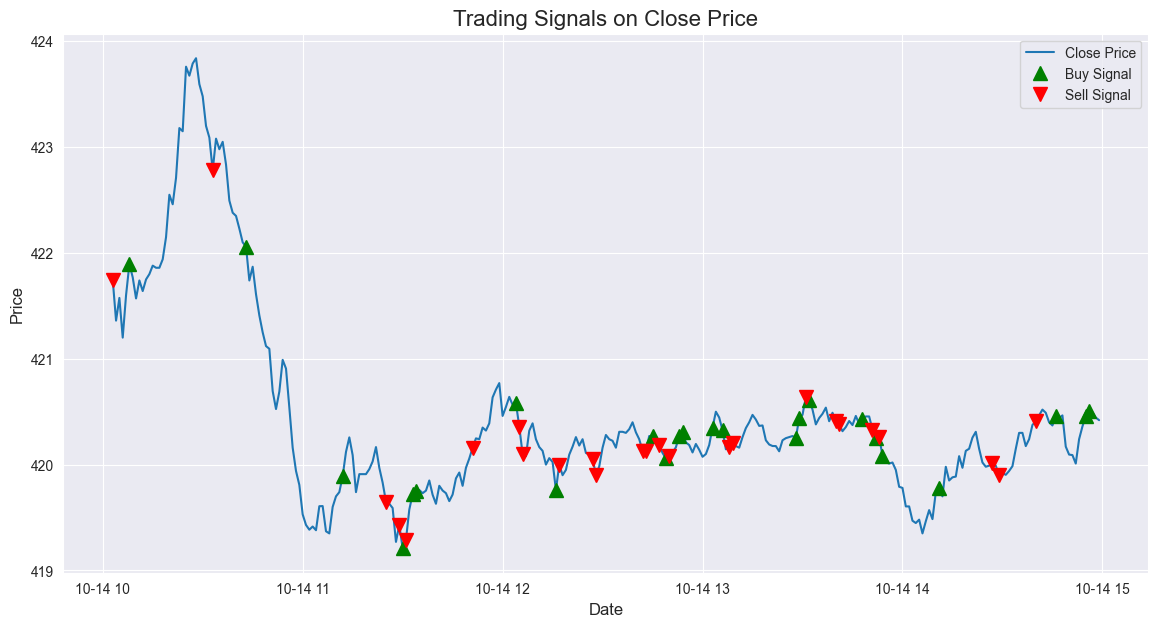

In [36]:
from software.plot_draws import plot_signals


plot_signals(result["signals"], result["signals"])